In [1]:
import pandas as pd
import json
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from operator import itemgetter
import matplotlib.pyplot as plt

In [2]:
#scapes google news for the query requested at the month in YYYY-MM format
#if month not in correct format, cannot gurantee articles from expected month
#return list of dictionary objects that can be written to json file
def scrape(query, month=""):

    last_day = 31
    time = ""

    if(month[-2:] == '02'):
        last_day = 28
    elif(month[-2:] in ['04', '06', '09', '11']):
        last_day = 30

    if(month != ""):
        #last_day > 10 so no date formatting issues
        time = "after:" + month + "-01" + " AND before:" + month + "-" + str(last_day) 
    news = "https://news.google.com"
    headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) \
    AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36'}
    
    #query google news and get all links 
    page = requests.get("https://news.google.com/search?q=" + query + " " + time, headers=headers)
    soup = BeautifulSoup(page.content, features="lxml")
    found = soup.findAll("a")
    links = [x.get('href') for x in found]
    temp = []
    redirects = []
    articles = []
    count = 0
    for l in links:
        if(type(l) == str):
            if 'article' in l:
                if l not in redirects:
                    redirects.append(l)
                    count += 1

    redirects = [x[1:] for x in redirects]
    
    #all links on google news are redirect links so we must
    #request the real url
    for a in redirects:
        try:
            r = requests.get(news + a, timeout=10)
            articles.append(r.url)
        except Exception as e:
            print(e)

    #browser header so that websites accept our requests
    user_agent = 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) \
    AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36'
    config = Config()
    config.browser_user_agent = user_agent

    a = None
    data = []
    
    #iterate through each article url and retrieve
    #url, title, authors, date, keywords, summary
    for url in articles: 
        try:
            a = Article(url, config=config)
            a.download()
            a.parse()
            a.nlp()
            
            d ={"url": url,
                "title": a.title,
                "authors": a.authors,
                "date": a.publish_date.date(),
                "keywords": a.keywords,
                "summary": a.summary,
                #If you want to include article text, uncomment this line
                #"text": a.text
                }
            data.append(d)
        except Exception as e:
            pass
        
    #return list of dictionary objects
    return data

In [4]:
#Read all cities and put them in cities list
cities = []
with open('cities.txt') as file:
    cities = list(file)

#Remove new line character from each city name
cities = [x[:-1] for x in cities]

In [5]:
#Load all city json objects into dfs
dfs = {}
for c in cities:
    with open('items/' + c + '.json') as file:
        dfs[c] = json.load(file)
        
#Make sure we loaded all 100 json files correctly
print(len(dfs))

100


In [6]:
#Find most popular key words for a given city

#change city to another city in cities for different results
city = "Orlando, Florida"
articles = dfs[city]

#Gets count of each keyword from all the articles

count = {}
for a in articles:
    for word in a['keywords']:
        if word in count:
            count[word] += 1
        else:
            count[word] = 1
#Sorts by most common keywords
count = {k: v for k, v in sorted(count.items(), key=lambda item: item[1])}
t = list(count.keys())
t = list(reversed(t))

#Prints most common keywords in order to screen
for i in range(50):
    print(t[i], count[t[i]])
    

florida 264
orlando 217
central 110
coronavirus 74
county 58
way 53
2020 52
park 49
state 48
orange 47
deaths 46
team 40
free 39
public 37
support 37
weekly 36
coverage 35
family 35
tirelessly 34
true 34
uncensored 34
works 34
health 34
fl 33
weather 32
2019 31
legal 31
notices 31
court 30
world 28
issue 27
man 27
disney 24
officials 23
high 23
week 23
tour 21
cases 21
theme 20
winter 20
items 19
personal 19
shot 19
shooting 19
event 19
record 19
low 19
trump 19
covid19 18
household 18


In [7]:
#Object to perform sentiment analysis
#Scores each article from -1 to 1
#Positve score tends towards positive article
#Negative score tends towards negative article
#Zero score tends towards neutral article
sia = SentimentIntensityAnalyzer()

#Get the sentiment score for each article for each city and add them to the json object
for c in dfs:
    for i in range(len(dfs[c])):
        dfs[c][i]['score'] = sia.polarity_scores(dfs[c][i]['summary'])['compound']
        
#This can be changed so that each article is scored when scraped so we shouldn't need to do this in future
#I did not add it in when scraping because I wanted to find something better than VADER, but never did

In [8]:
#List the average positive/negative score for each city
scores = []
for c in dfs:
    average = 0
    for i in range(len(dfs[c])):
        average += dfs[c][i]['score']
    average /= len(dfs[c])
    scores.append((c, average))
    
#Sort the cities from highest to lowest average score
sorted_scores = sorted(scores, key=itemgetter(1), reverse=True)
count = 0
#Print all the citites and their average sentiment score
for s in sorted_scores:
    count += 1
    print(count, s)

1 ('Madison, Wisconsin', 0.4845871212121212)
2 ('Scottsdale, Arizona', 0.4499853881278539)
3 ('Denver, Colorado', 0.41199017543859706)
4 ('Phoenix, Arizona', 0.38127745535714314)
5 ('Atlanta, Georgia', 0.375253072625698)
6 ('Washington, DC', 0.3647509485094849)
7 ('Tampa, Florida', 0.36463327370304155)
8 ('Portland, Oregon', 0.35388864197530834)
9 ('St. Petersburg, Florida', 0.3476966740576493)
10 ('Plano, Texas', 0.33654360000000005)
11 ('Nashville, Tennessee', 0.33402028639618125)
12 ('Austin, Texas', 0.31852379110251494)
13 ('Irvine, California', 0.3175016822429908)
14 ('St. Louis, Missouri', 0.31672021857923516)
15 ('San Antonio, Texas', 0.3136752495009981)
16 ('Charlotte, North Carolina', 0.3096427184466022)
17 ('Miami, Florida', 0.2823765625)
18 ('Reno, Nevada', 0.28039190476190495)
19 ('Louisville Kentucky', 0.2782285211267606)
20 ('San Diego, California', 0.275814498141264)
21 ('Irving, Texas', 0.27475332068311187)
22 ('Minneapolis, Minnesota', 0.27221435643564335)
23 ('Houston

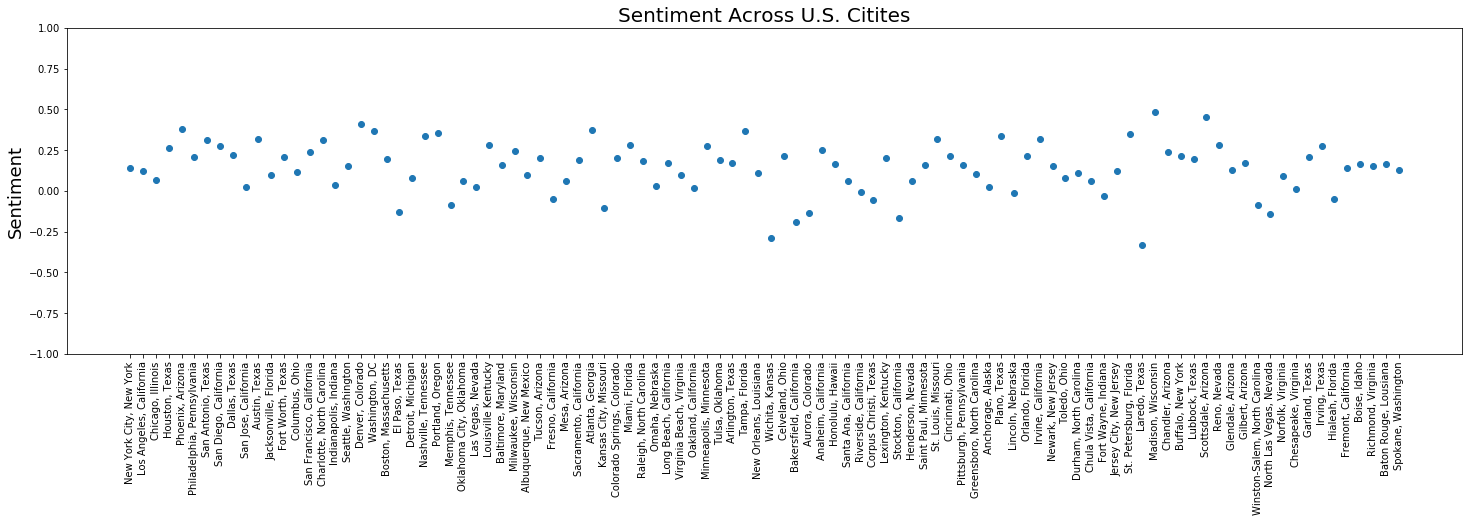

In [9]:
s,t = zip(*scores)
plt.figure(figsize=(25, 6))
plt.scatter(s,t);
plt.xticks(rotation="vertical");
plt.ylabel("Sentiment", fontsize = 18)
plt.ylim(-1,1)
plt.title("Sentiment Across U.S. Citites", fontsize = 20)
plt.show()

In [10]:
def get_average(city):
    average = 0
    for i in range(len(dfs[city])):
        average += dfs[city][i]['score']
    average /= len(dfs[city])
    return average

In [11]:
def get_monthly_average(city):

    monthly_scores = {}

    #Possible months of articles in dataset
    #Can be made more general but is enough for our purposes
    months = {'2019-10': [], 
              '2019-11': [], 
              '2019-12': [], 
              '2020-01': [],
              '2020-02': [], 
              '2020-03': [], 
              '2020-04': []}

    articles = dfs[city]

    #Places each article in corect month
    for i in range(len(articles)):
        if articles[i]['date'][:7] in months:
            months[articles[i]['date'][:7]].append(articles[i])

    #Calculate the average sentiment score for each month
    for m in months:
        average = 0
        for i in range(len(months[m])):
            average += months[m][i]['score']
        if(len(months[m]) != 0):
            average /= len(months[m])
            
        monthly_scores[m] = average

    #for s in monthly_scores:
        #print(s, monthly_scores[s])

    monthly_scores = sorted(monthly_scores.items())

    #x,y = zip(*monthly_scores)
    return monthly_scores

#get_monthly_average(city)

In [14]:
#You can see how accuracte the sentiment analysis is basted on the title
for a in dfs[city]:
    print(a['title'], a['score'])


NFL invites 58 top prospects to participate virtually in 2020 draft 0.5859
Black News Channel co-founder, CEO Bob Brillante steps down two months after national launch 0.1531
Free Things To Do In Orlando This January 2020 0.8603
Florida coronavirus update for Wednesday: 8 deaths, more than 100 new cases across state; Trump signs aid package -0.5423
Weber Adds Lewis, Williams to K-State’s 2020 Signing Class -0.7269
Weather Forecast: Warm Weather Continues Into Next Week 0.7845
Weather Forecast: Potential Areas of Fog Overnight, Early Morning 0.3197
January Calendar 0.7845
Deaths in Central Florida: 1/19 0.0716
What’s that smoke? Haze from controlled burns blankets Central Florida 0.2263
Here’s what’s coming to the Orlando area in 2020 0.0
Heat wave? Big-time warmup coming to Orlando area -0.0772
Weather Forecast: Warmer Weather Expected Tuesday 0.8126
Weather Forecast: Close to Record Highs Expected Friday 0.778
Photos: Orlando (FL) Firefighters Extinguish House Fire -0.5859
Deaths in C

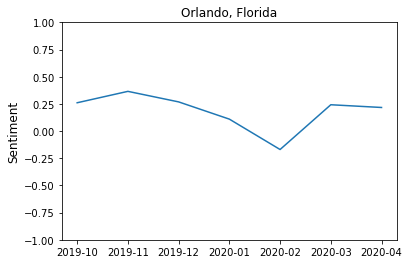

In [23]:
#City sentiment score plotted over months

x, y = zip(*get_monthly_average(city))
plt.title(city)
plt.plot(x,y);
plt.ylim(-1,1)
plt.ylabel("Sentiment", fontsize = 12)
plt.show();

In [24]:
#This was to combine the top 10 cities into a single json file to look at in tableau
#But it seems that it's still too big for Tableau
top = {}
for c in cities[:10]:
    top[c] = {}
    with open('items/' + c + '.json') as file:
        top[c]['articles'] = json.load(file)
        top[c]['average'] = get_average(c)
        top[c]['monthly_average'] = get_monthly_average(c)
        

with open('combine.json', 'w+') as file:
    json.dump(top, file)


In [25]:
for c in top:
    print(c, top[c]['average'])
    for m in top[c]['monthly_average']:
        print(m)

New York City, New York 0.13901653061224484
('2019-10', 0.39291600000000004)
('2019-11', 0.4256260869565217)
('2019-12', 0.22412321428571427)
('2020-01', 0.27501000000000003)
('2020-02', 0.251365)
('2020-03', 0.0002500000000000289)
('2020-04', -0.0861878787878788)
Los Angeles, California 0.12353761638733707
('2019-10', -0.0052169230769230895)
('2019-11', 0.17526029411764701)
('2019-12', 0.2681315068493152)
('2020-01', 0.29729687499999996)
('2020-02', 0.3036938775510204)
('2020-03', -0.08164553571428576)
('2020-04', 0.040598913043478235)
Chicago, Illinois 0.06606131528046429
('2019-10', 0.10509166666666664)
('2019-11', 0.20479210526315791)
('2019-12', 0.10877303370786519)
('2020-01', -0.13248000000000004)
('2020-02', -0.2743271428571428)
('2020-03', 0.18597582417582414)
('2020-04', -0.051060416666666664)
Houston, Texas 0.2612290465631928
('2019-10', 0.3250050000000001)
('2019-11', 0.3097807017543859)
('2019-12', 0.2297582089552239)
('2020-01', 0.36996153846153845)
('2020-02', 0.29841694

In [26]:
#Read all compaies and put them in companies list
companies = []
with open('companies.txt') as file:
    companies = list(file)

#Remove new line character from each city name
companies = [x[:-1] for x in companies]

In [29]:
#Load all company json objects into comp
comp = {}
for c in companies:
    with open('other/' + c + '.json') as file:
        comp[c] = json.load(file)
        
#Make sure we loaded all 5 json files correctly
print(len(comp))

5


In [30]:
sia = SentimentIntensityAnalyzer()

#Get the sentiment score for each article for each city and add them to the json object
for c in comp:
    for i in range(len(comp[c])):
        comp[c][i]['score'] = sia.polarity_scores(comp[c][i]['summary'])['compound']
        

#List the average positive/negative score for each city
comp_scores = []
for c in comp:
    average = 0
    for i in range(len(comp[c])):
        average += comp[c][i]['score']
    average /= len(comp[c])
    comp_scores.append((c, average))
    
#Sort the cities from highest to lowest average score
sorted_comp_scores = sorted(comp_scores, key=itemgetter(1), reverse=True)
count = 0
#Print all the citites and their average sentiment score
for s in sorted_comp_scores:
    count += 1
    print(count, s)
    
#Just to briefly show that all of this can be done with more than just cities

1 ('Amazon', 0.5477260215053767)
2 ('Apple', 0.4235945454545455)
3 ('Microsoft', 0.3902041450777204)
4 ('Google', 0.31412707423580805)
5 ('Facebook', 0.13187424242424242)
